In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from keras.layers import Input, Dense
from keras.models import Model
import sys
# src folder
sys.path.insert(0, "../")
# autoencoders lib
from autoencoders import get_simple_autoencoder
from utils import lift_summary

Using TensorFlow backend.


## Read data

In [2]:
# The used dataset is available in https://www.kaggle.com/mlg-ulb/creditcardfraud
df = pd.read_csv("../../data/creditcard.csv")
# Show Nb rows, Nb cols
df.shape

(284807, 31)

In [3]:
# Show header
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115  0.133558 -0.021053  149.62      0  
1  0.167170  0.125895 -0.008983  0.014724    2.69      0  
2 -0.327642 -0.139097 -0.055353 -0.059752  378.66      0  
3  0.647376 -0.221929  0.062723  0.061458  123.50      0  
4 -0.206010  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

## Exploratory analysis

In [4]:
# Review target columns - we only have 492 true observations out of almost 285K
# That means that we have a 0.17% of fraud rate in the dataset
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
# NA check - not a single NA in any column
# No need to handle NA
df.isna().sum().any()

False

In [6]:
# We will not do a time-dynamic analysis, so the Time columns will be dropped
df = df.drop(columns=['Time'])

### Univariate analysis

/home/sgamez/anaconda3/envs/kerasenv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


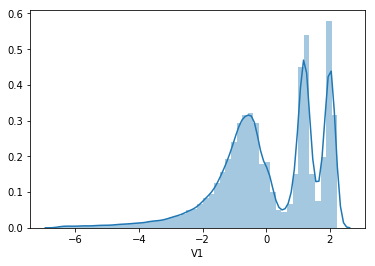

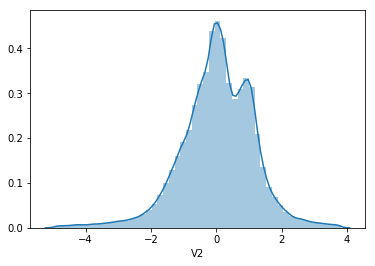

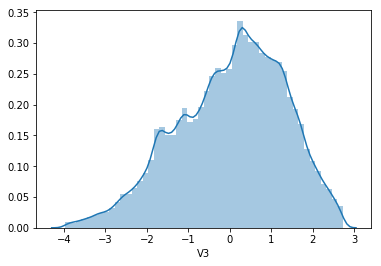

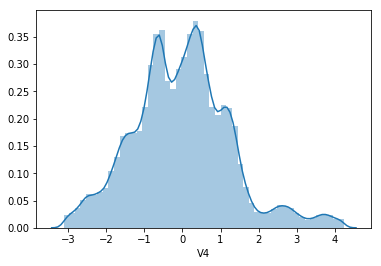

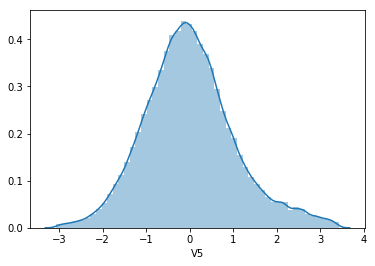

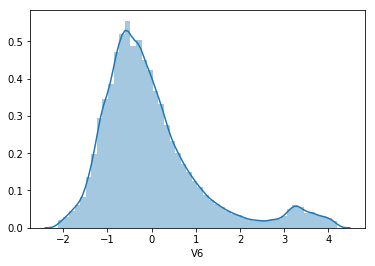

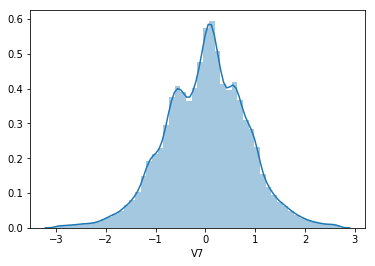

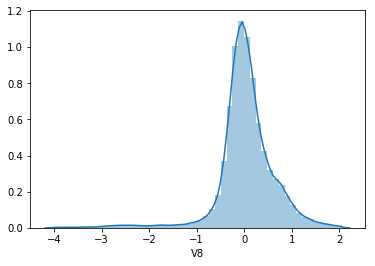

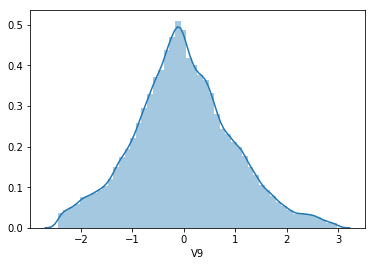

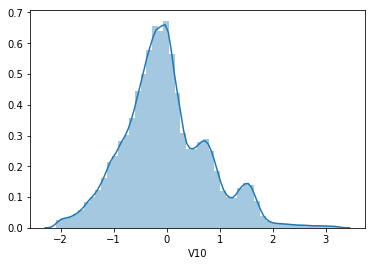

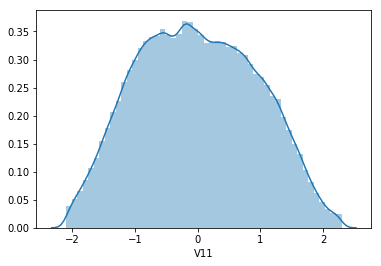

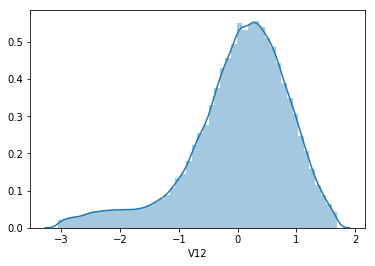

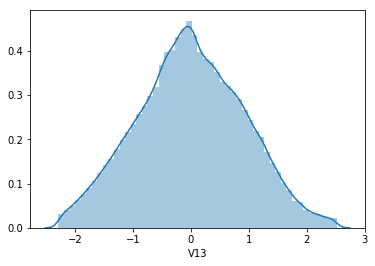

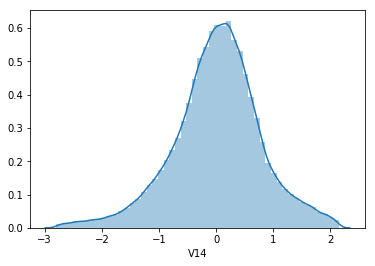

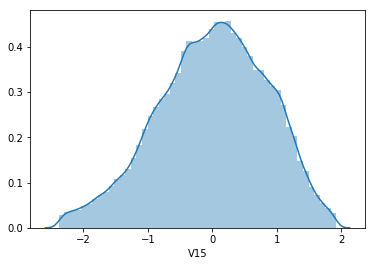

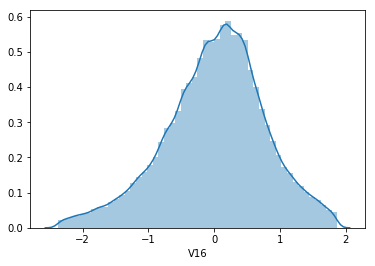

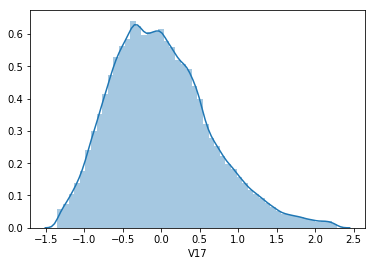

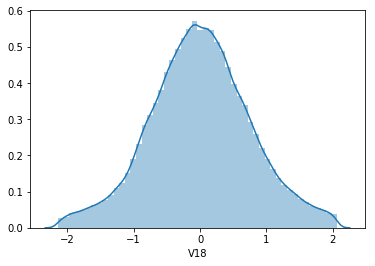

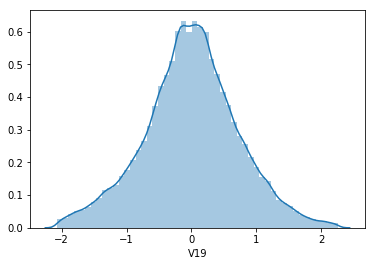

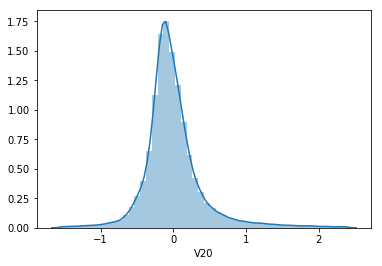

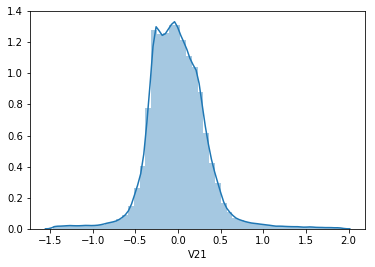

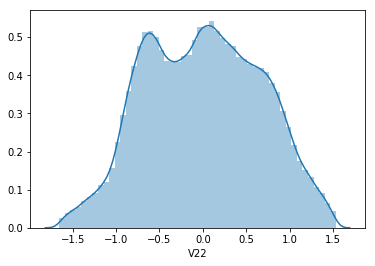

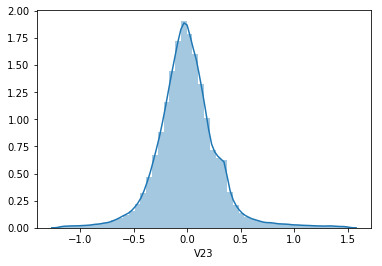

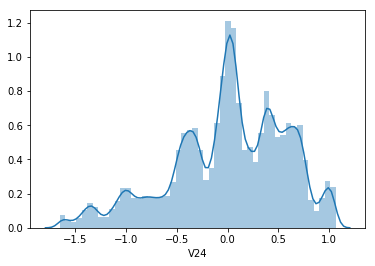

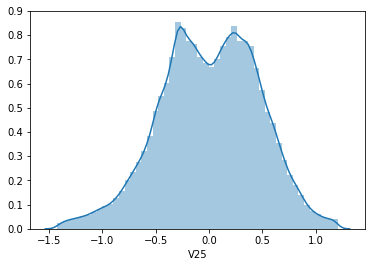

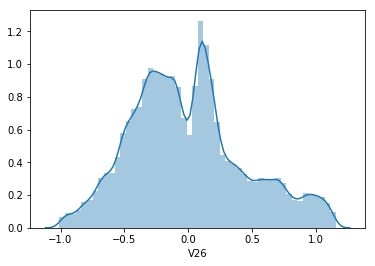

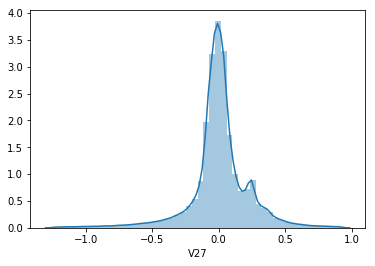

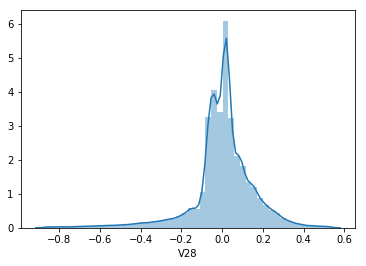

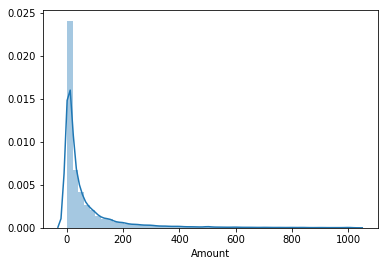

In [7]:
# Capture the target column and the features
target_col = 'Class'
features = [c for c in df.columns if c!= target_col]
# Outlier removal treshold
TH_outliers = 0.01
for feat in features:
    #drop top / bottom x% to remove outliers
    perc_cuts = df[feat].quantile(q=[TH_outliers, 1. - TH_outliers])
    feat_series = df[df[feat].between(*perc_cuts)][feat]
    sns.distplot(feat_series)
    plt.show()

### Bivariate analysis

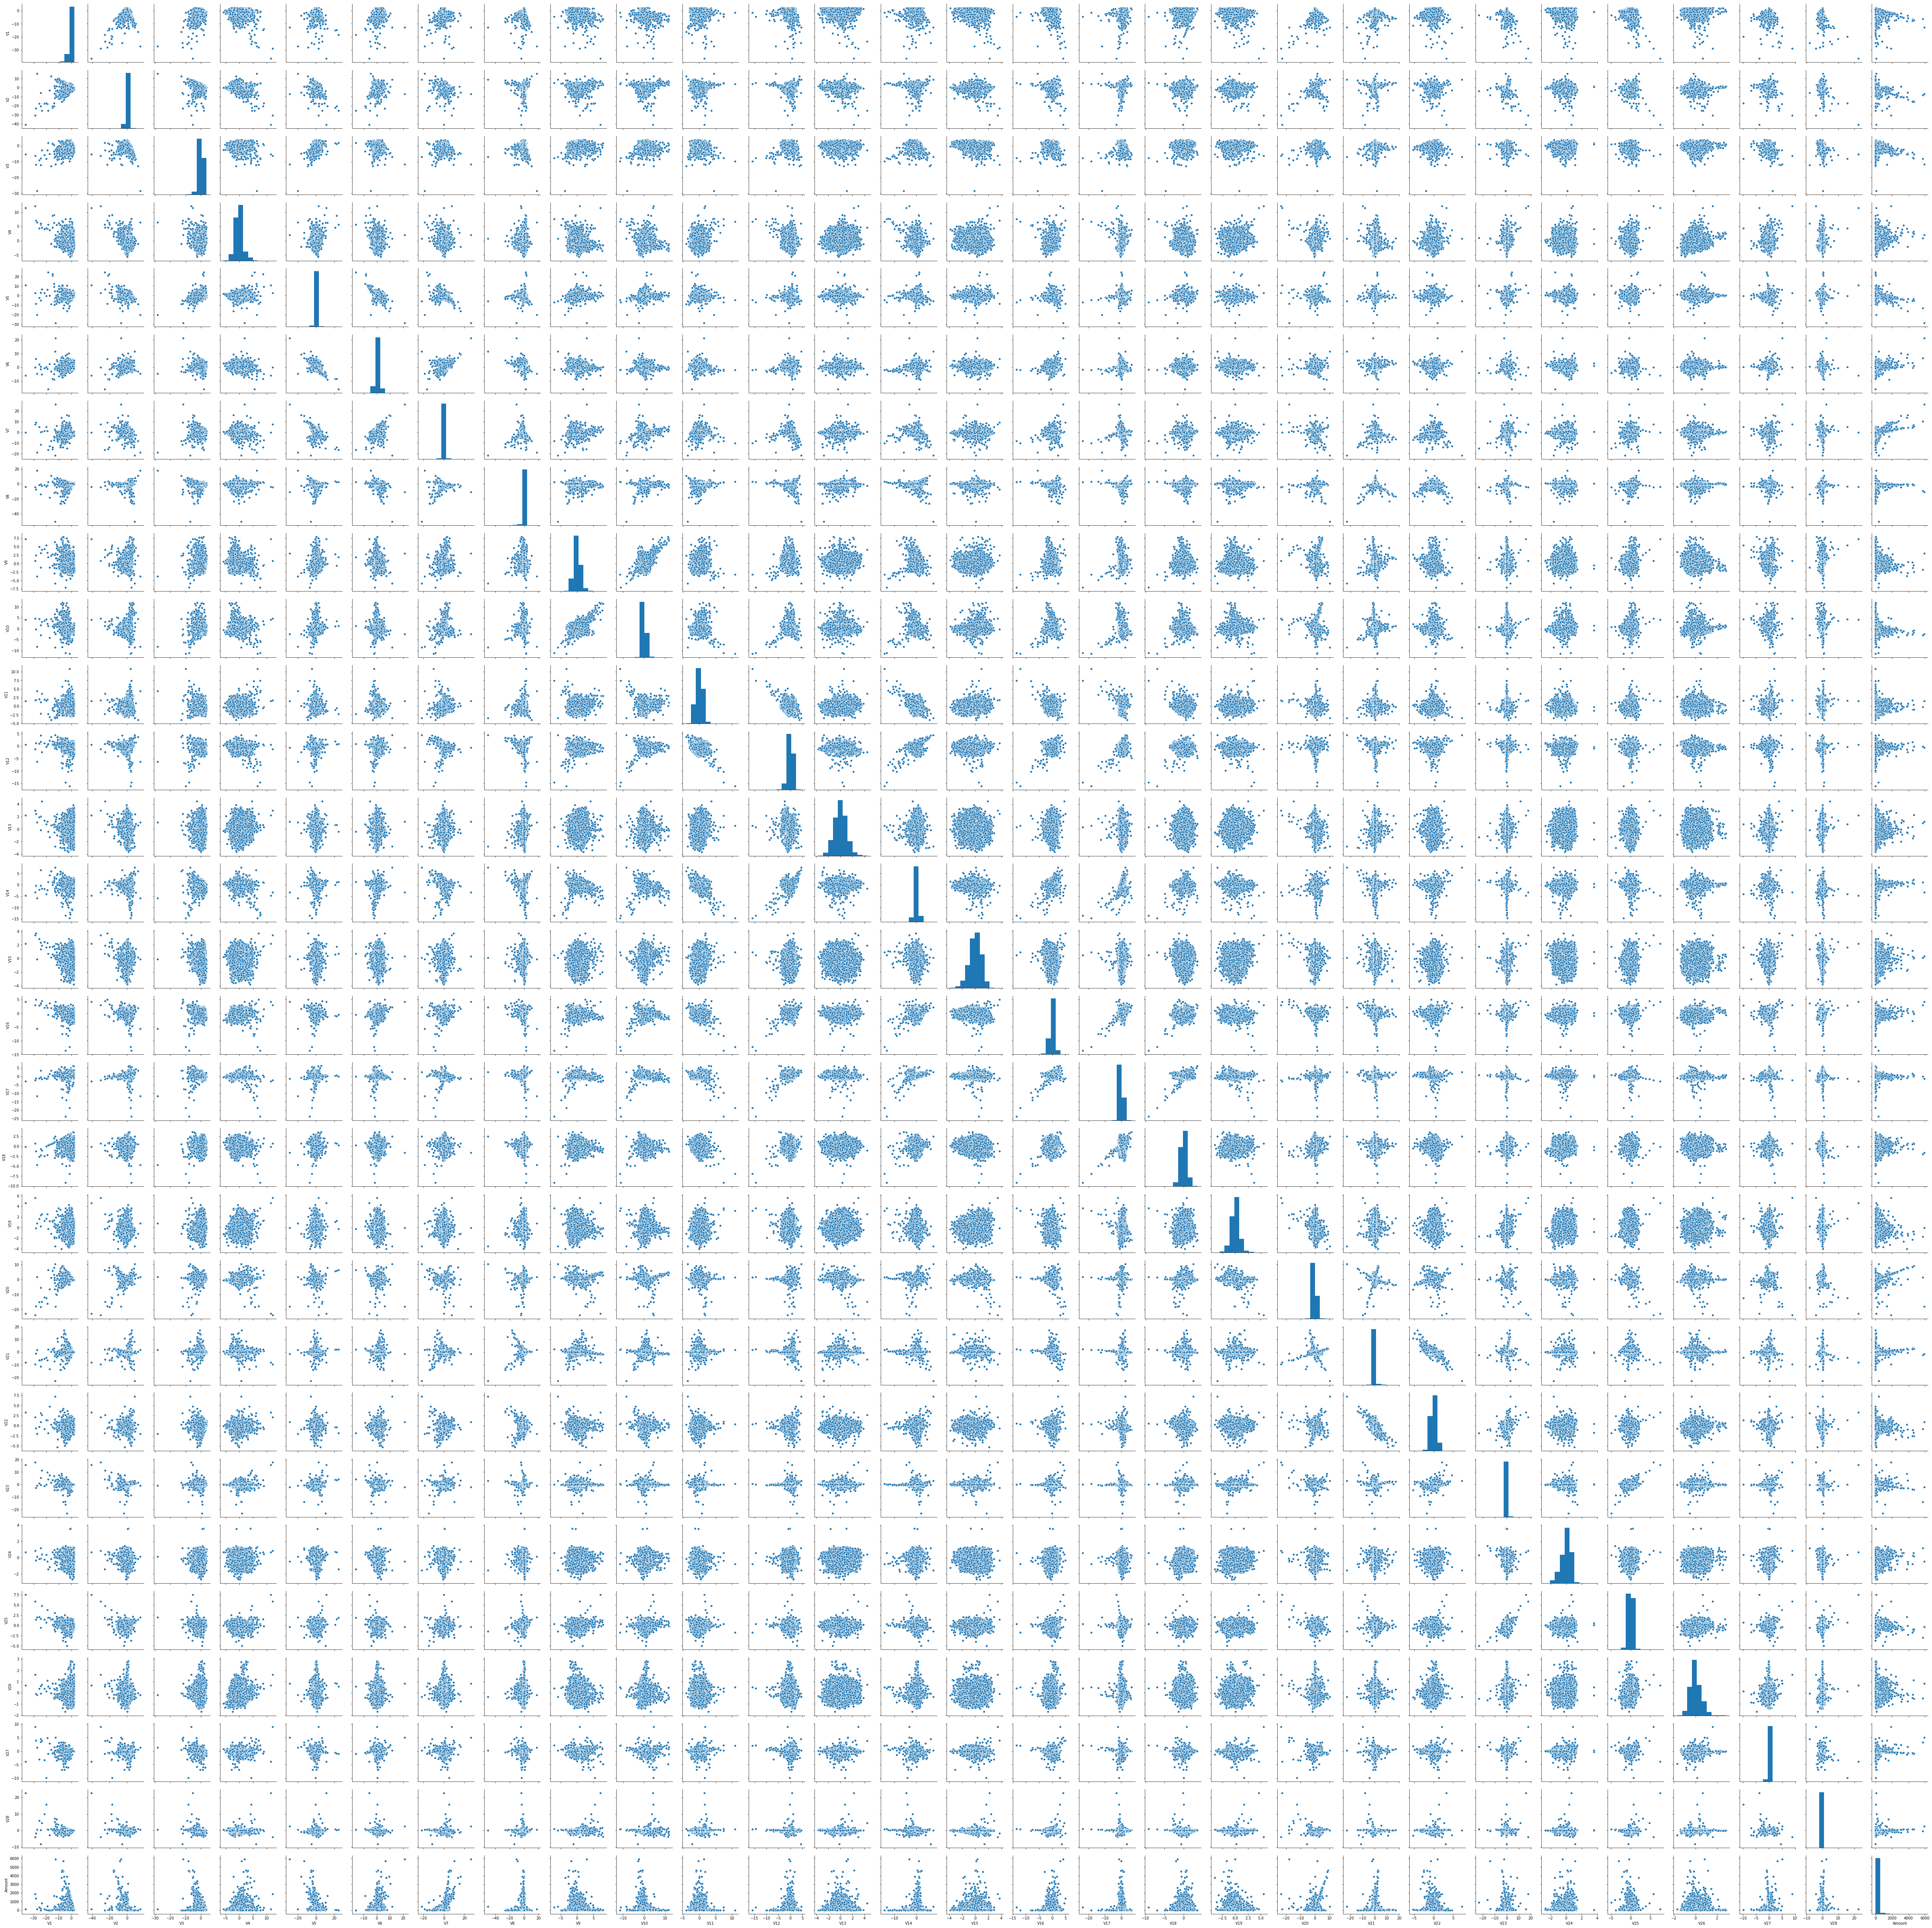

In [8]:
# Using a sample because otherwise it takes forever
sns.pairplot(df[features].sample(frac=0.05))

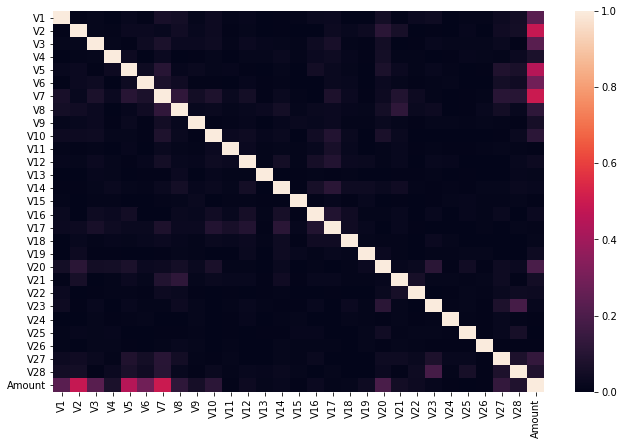

In [9]:
# Correlation plot
corr = df[features].sample(frac=0.05).corr()
plt.figure(figsize=(11, 7))
sns.heatmap(corr.abs(),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            vmin=0.,
            vmax=1)

### Data distribution vs target feature

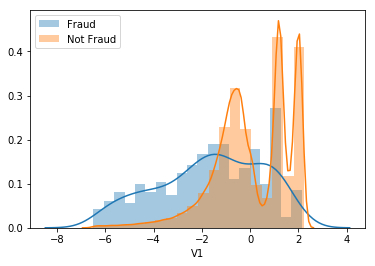

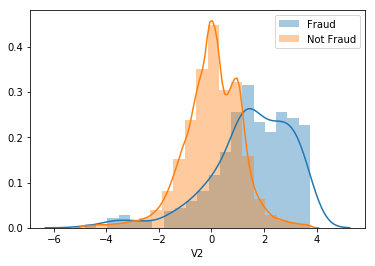

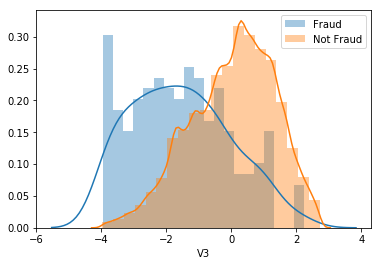

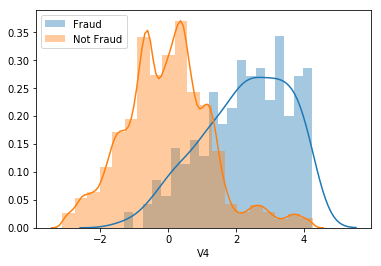

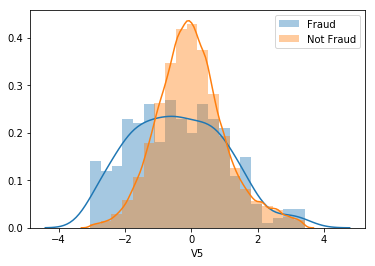

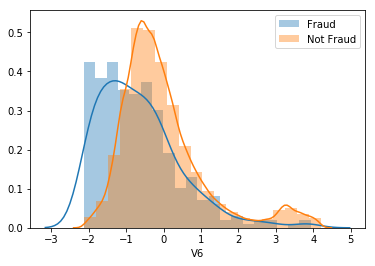

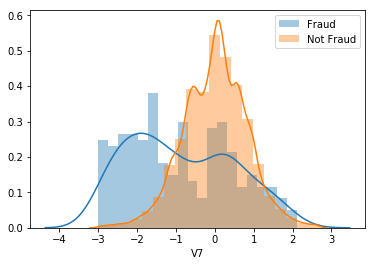

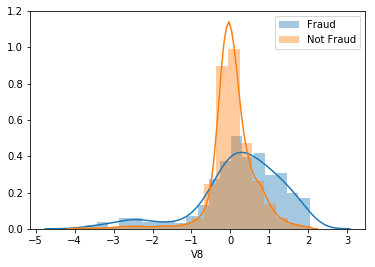

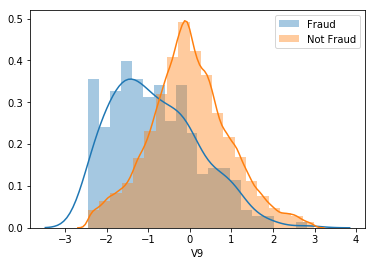

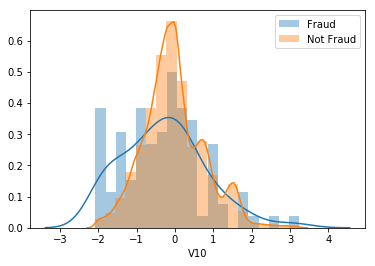

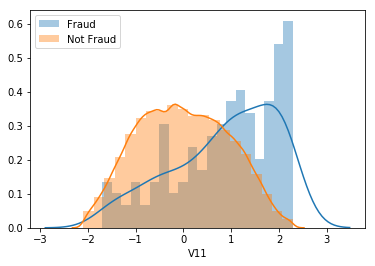

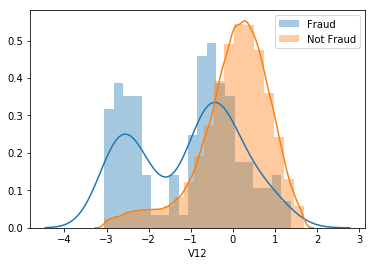

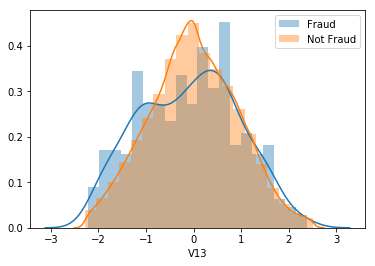

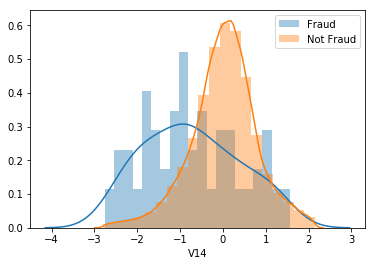

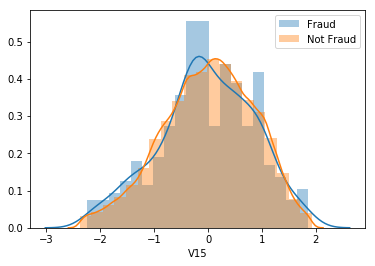

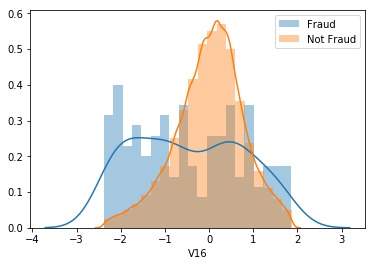

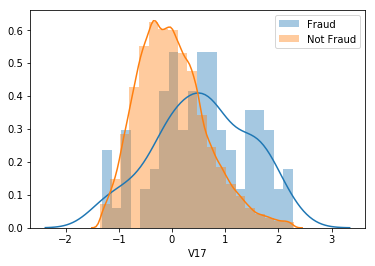

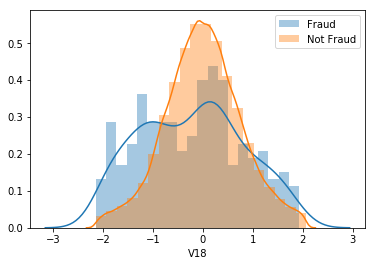

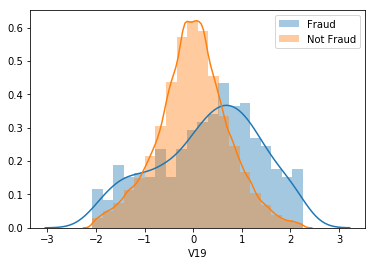

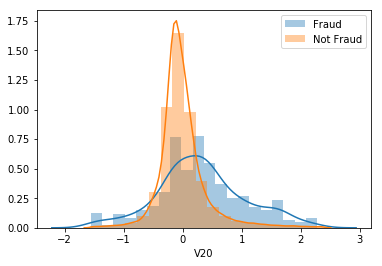

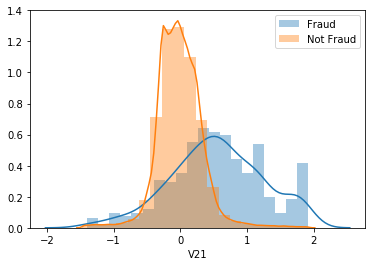

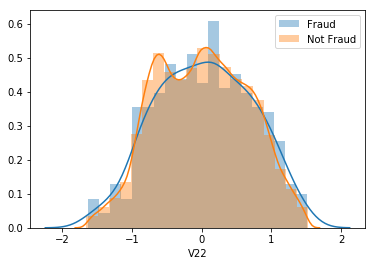

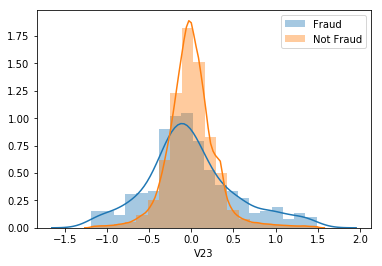

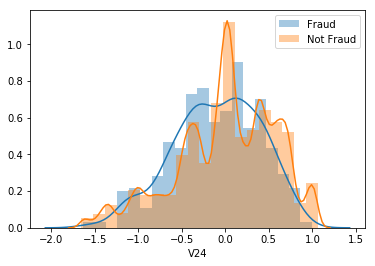

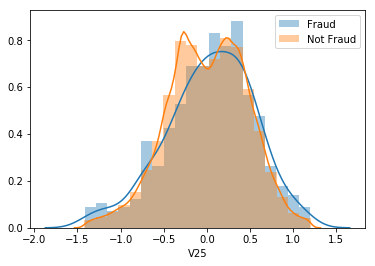

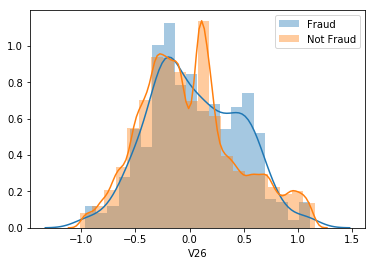

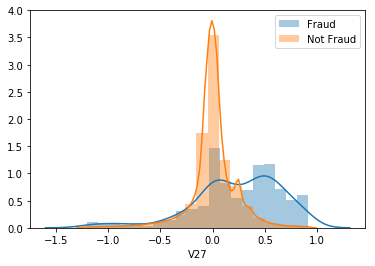

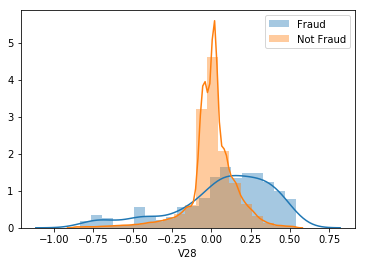

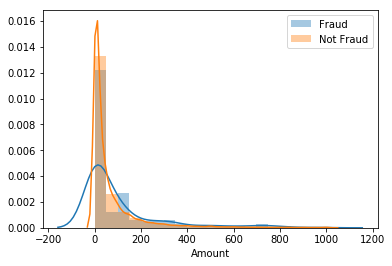

In [10]:
for feat in features:
    # drop top / bottom x% to remove outliers
    perc_cuts = df[feat].quantile(q=[TH_outliers, 1. - TH_outliers])
    df_cut = df[df[feat].between(*perc_cuts)]
    # capture fraud and not fraud entries
    series_fraud = df_cut.loc[df_cut.Class == 1][feat]
    series_nfraud = df_cut.loc[df_cut.Class == 0][feat]
    sns.distplot(series_fraud, bins=20, label='Fraud')
    sns.distplot(series_nfraud, bins=20, label='Not Fraud')
    plt.legend()
    plt.show()

## Autoencoder modelling

In [11]:
# Set the compresion factor
COMP_FACTOR = 2
# Get the data columns out of the dataframe
X_base = df[features]
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_base, df.Class, test_size=0.2)
X_base.shape, X_train.shape, X_test.shape

((284807, 29), (227845, 29), (56962, 29))

In [12]:
# Data preprocessing 
# Use StandardScaler in order to set mean to 0 and have unit variance
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
autoencoder, encoder, decoder = get_simple_autoencoder(X_train, COMP_FACTOR)

In [14]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 227845 samples, validate on 56962 samples
Epoch 1/30
227845/227845 [==============================] - 4s 16us/step - loss: -2.6468 - val_loss: -4.0087
Epoch 2/30
227845/227845 [==============================] - 3s 11us/step - loss: -4.2105 - val_loss: -4.3695
Epoch 3/30
227845/227845 [==============================] - 2s 11us/step - loss: -4.4339 - val_loss: -4.5181
Epoch 4/30
227845/227845 [==============================] - 3s 11us/step - loss: -4.5570 - val_loss: -4.6198
Epoch 5/30
227845/227845 [==============================] - 3s 11us/step - loss: -4.6480 - val_loss: -4.6962
Epoch 6/30
227845/227845 [==============================] - 2s 11us/step - loss: -4.7135 - val_loss: -4.7530
Epoch 7/30
227845/227845 [==============================] - 3s 11us/step - loss: -4.7622 - val_loss: -4.7954
Epoch 8/30
227845/227845 [==============================] - 3s 11us/step - loss: -4.7988 - val_loss: -4.8288
Epoch 9/30
227845/227845 [==============================] - 3s 11us/step - lo

In [15]:
encoded_train = encoder.predict(X_train)
decoded_train = decoder.predict(encoded_train)

encoded_test = encoder.predict(X_test)
decoded_test = decoder.predict(encoded_test)

In [16]:
dist_train = np.apply_along_axis(np.linalg.norm, axis=1, arr=(X_train - decoded_train))
dist_test = np.apply_along_axis(np.linalg.norm, axis=1, arr=(X_test - decoded_test))

(array([2.25543e+05, 1.82400e+03, 2.83000e+02, 1.29000e+02, 4.30000e+01,
        1.50000e+01, 4.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([  1.16661266,  13.84230087,  26.51798908,  39.1936773 ,
         51.86936551,  64.54505373,  77.22074194,  89.89643015,
        102.57211837, 115.24780658, 127.92349479]),
 <a list of 10 Patch objects>)

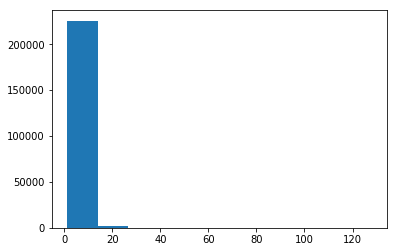

In [17]:
plt.hist(dist_train)

(array([5.6812e+04, 1.2200e+02, 2.2000e+01, 4.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.09119651,  22.94806505,  44.80493359,  66.66180213,
         88.51867067, 110.37553921, 132.23240775, 154.08927629,
        175.94614483, 197.80301337, 219.65988191]),
 <a list of 10 Patch objects>)

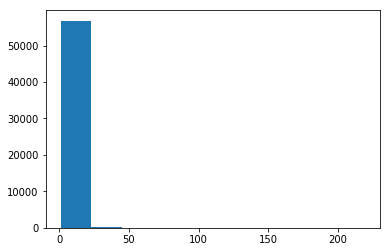

In [18]:
plt.hist(dist_test)

In [19]:
np.mean(dist_train), np.mean(dist_test)

(3.788016026727255, 3.803919055120899)

## Evaluation

### Lift evaluation

In [20]:
df_eval_train = pd.DataFrame({'class': y_train,
                              'dist': dist_train})
df_eval_test = pd.DataFrame({'class': y_test,
                             'dist': dist_test})

In [21]:
df_eval_train.groupby('class')['dist'].mean()

class
0     3.758097
1    20.800373
Name: dist, dtype: float64

In [22]:
df_eval_test.groupby('class')['dist'].mean()

class
0     3.774006
1    22.294752
Name: dist, dtype: float64

In [23]:
lift_summary(df_eval_train)

Pcts      Nb  Cum_sum       Lift
0    1.0    2279      237  59.235701
1    5.0    9114      348   6.937348
2   10.0   11392      356   0.400009
3   20.0   22784      365   0.225005
4  100.0  182275      400   0.109376

In [24]:
lift_summary(df_eval_test)

Pcts     Nb  Cum_sum       Lift
0    1.0    570       63  68.432609
1    5.0   2279       84   5.705220
2   10.0   2848       88   0.869596
3   20.0   5694       88   0.000000
4  100.0  45570       92   0.054347

The base setting generates a significant lift, with a lift of almost 60 at top 1% in the test set.

### AUC

In [26]:
roc_auc_score(y_train, dist_train)

0.9472627118644068

In [27]:
roc_auc_score(y_test, dist_test)

0.9714661967416152